# Работа с данными. Домашнее задание


## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [1]:
import pandas as pd

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39
1,2,Male,NaN,NaN,81
2,3,Female,NaN,16.0,6
3,4,Female,23.0,16.0,77
4,5,Female,31.0,17.0,40


### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

In [3]:
df.isna().sum()


CustomerID                 0
Genre                     19
Age                       20
Annual Income (k$)        20
Spending Score (1-100)     0
dtype: int64

In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,180.000000,180.000000,200.000000
mean,100.500000,39.894444,5615.433333,50.200000
std,57.879185,16.842848,74531.115872,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,29.000000,42.000000,34.750000
50%,100.500000,36.000000,61.000000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,135.000000,1000000.000000,99.000000


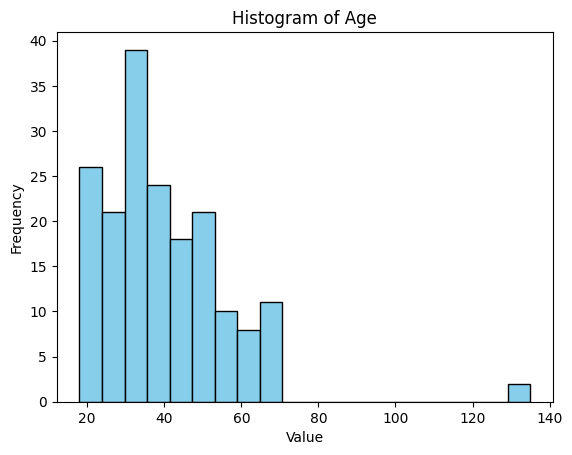

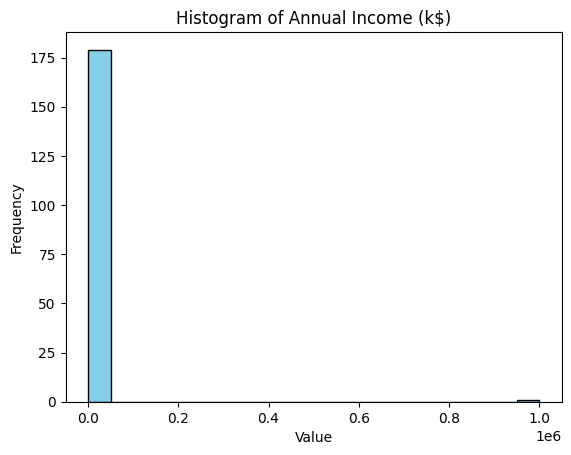

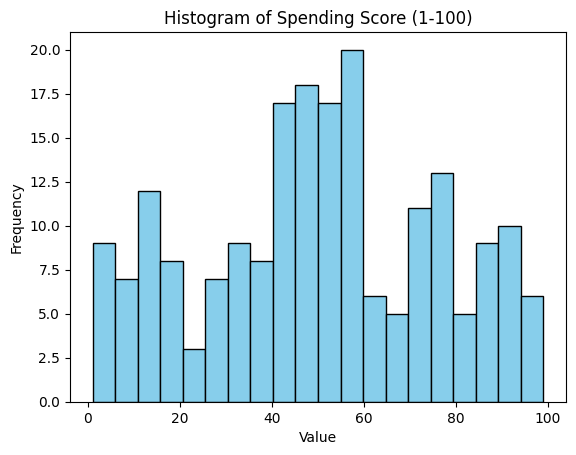

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


num_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for col in num_columns:
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()


In [11]:
df['Annual Income (k$)'].describe()

count        180.000000
mean        5615.433333
std        74531.115872
min           15.000000
25%           42.000000
50%           61.000000
75%           78.000000
max      1000000.000000
Name: Annual Income (k$), dtype: float64

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [ ]:
### YOUR CODE HERE ###


### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [ ]:
### YOUR CODE HERE ###


### Задание 5

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


In [ ]:
### YOUR CODE HERE ###


### Задание 6

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.


In [ ]:
### YOUR CODE HERE ###


### Задание 7

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.

In [ ]:
### YOUR CODE HERE ###


### Задание 8
Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [ ]:
### YOUR CODE HERE ###
